**Задание**

Реализуйте обучение нейронной сети из одного нейрона для задачи предсказания стоимости квартир <br> 

boston house prices https://www.kaggle.com/datasets/vikrishnan/boston-house-prices<br>
 или <br>
 california housing prices https://www.kaggle.com/datasets/camnugent/california-housing-prices<br>
 
  с использованием pytorch.

In [ ]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats as st
import torch
import random

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error

matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
warnings.filterwarnings(action="ignore", message="Mean of empty slice")

In [ ]:
def get_info_on_dataset(_df, _full = True):

    CONST_IN_PERCENTAGES = float(100.0)
    
    try:
        _df.info()
        df_review_info = pd.DataFrame({'Not_Valid_Values_in %': (_df.isna().sum()/len(_df))*CONST_IN_PERCENTAGES} )
        print("")
        print("Number of duplicated rows in the dataset: {}".format(_df.duplicated().sum()))
        print("")
        display(df_review_info.sort_values(by='Not_Valid_Values_in %', ascending=False))
    except:
        print("Can't provide review on given dataset")
    pass


def plot_df_coll_matrix(_df, _columns, _cell_annotation_font_size = 10):
    
    try:
        corr = _df[_columns].corr()
        fig, ax = plt.subplots(figsize=(10,8))           
        sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, cmap="rocket", annot_kws={'size': _cell_annotation_font_size})
    except:
        print("Can't provide pairwise correlation plotting")
    pass


def plot_hist(_x_data,_bins = 100, _x_ticks_range = [],
              _y_ticks_range = [], _outliers_removed = False,
              _kde = True, _x_axis_label = "x", _y_axis_label = "count", 
              _width = 12, _height = 8, _fontsize=12):
     
    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
        
    try:
        if(_outliers_removed):
            Q1 = _x_data.quantile(Q1_QUANTILE_VALUE_CONST)
            Q3 = _x_data.quantile(Q3_QUANTILE_VALUE_CONST)
            IQR = Q3 - Q1 
            
            outliers_low_bound = Q1 - IQR_MULT_DEFAULT_CONST*IQR
            outliers_upper_bound = Q3 + IQR_MULT_DEFAULT_CONST*IQR
            
            _x_data = _x_data[ (_x_data >= outliers_low_bound) & (_x_data <= outliers_upper_bound) ]
    
        fig = plt.figure(figsize=(_width, _height))
        sns.histplot(x=_x_data, bins=_bins, kde=_kde)
        plt.xlabel(_x_axis_label, fontsize=_fontsize)
        plt.ylabel(_y_axis_label, fontsize=_fontsize)
                
        if _x_ticks_range:
            plt.xlim(*_x_ticks_range) 
        if _y_ticks_range:
            plt.ylim(*_y_ticks_range)
    except:
        print("Can't provide histogram plotting")
    pass

In [ ]:
RANDOM_STATE = 42
ML_TEST_SUBSET_SIZE_VALUE_CONST = 0.2
NUM_EPOCHS = 100
LR = 0.01
BATCH_SIZE = 10
NUM_INPUTS = 13
NUM_EXAMPLES = 404

## Загрузка данных

Content
Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): 
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10000 USD
11. PTRATIO: pupil-teacher ratio by town 12. 
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000s USD.

We can see that the input attributes have a mixture of units.

In [ ]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

try:
    df_bh = pd.read_csv('/content/housing.csv', sep="\s+", names=column_names)
except:
    df_bh = pd.read_csv('housing.csv', sep="\s+", names=column_names)

In [ ]:
get_info_on_dataset(df_bh)
df_bh.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB

Number of duplicated rows in the dataset: 0



,Not_Valid_Values_in %
CRIM,0.0
ZN,0.0
INDUS,0.0
CHAS,0.0
NOX,0.0
RM,0.0
AGE,0.0
DIS,0.0
RAD,0.0
TAX,0.0


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
df_bh.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


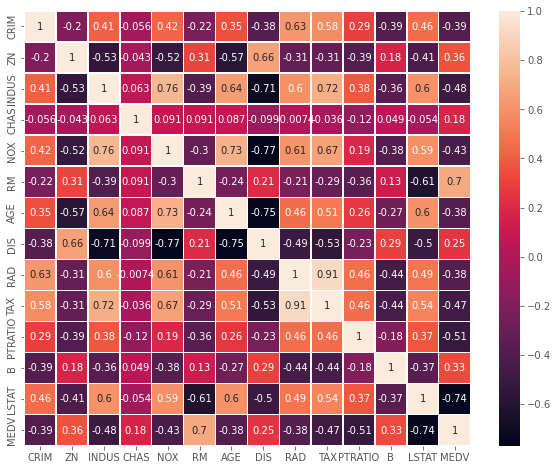

In [ ]:
plot_df_coll_matrix(df_bh, column_names)

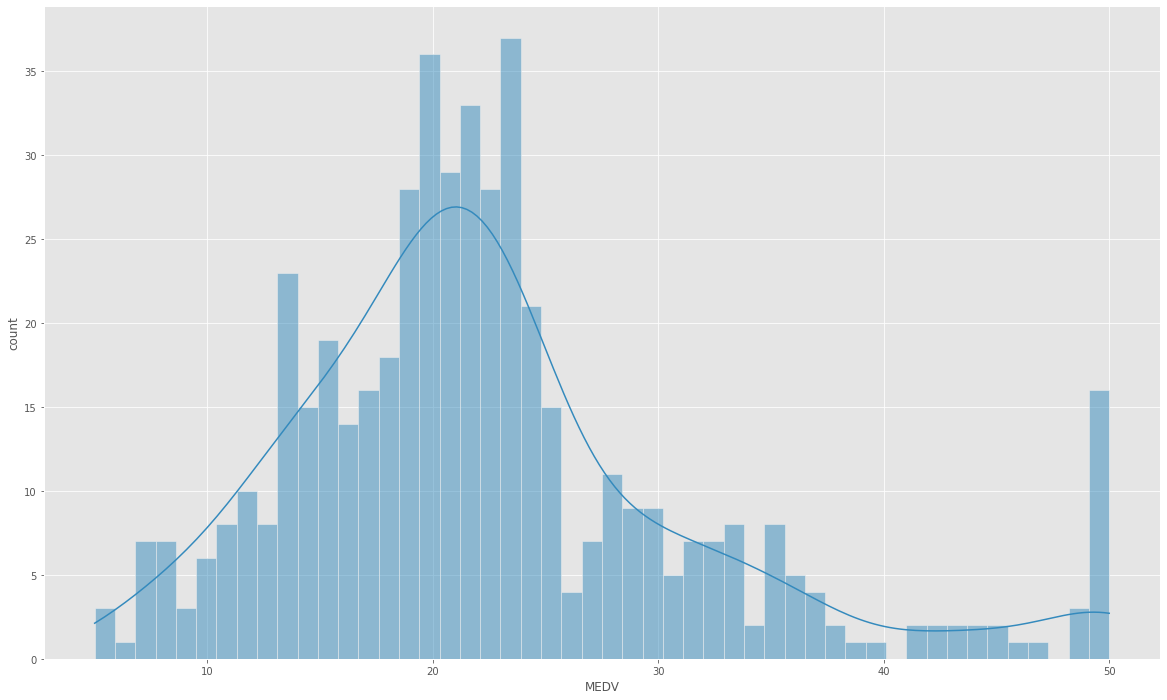

In [ ]:
plot_hist(df_bh.MEDV, _x_axis_label = "MEDV", _bins = 50, _width = 20, _height = 12)

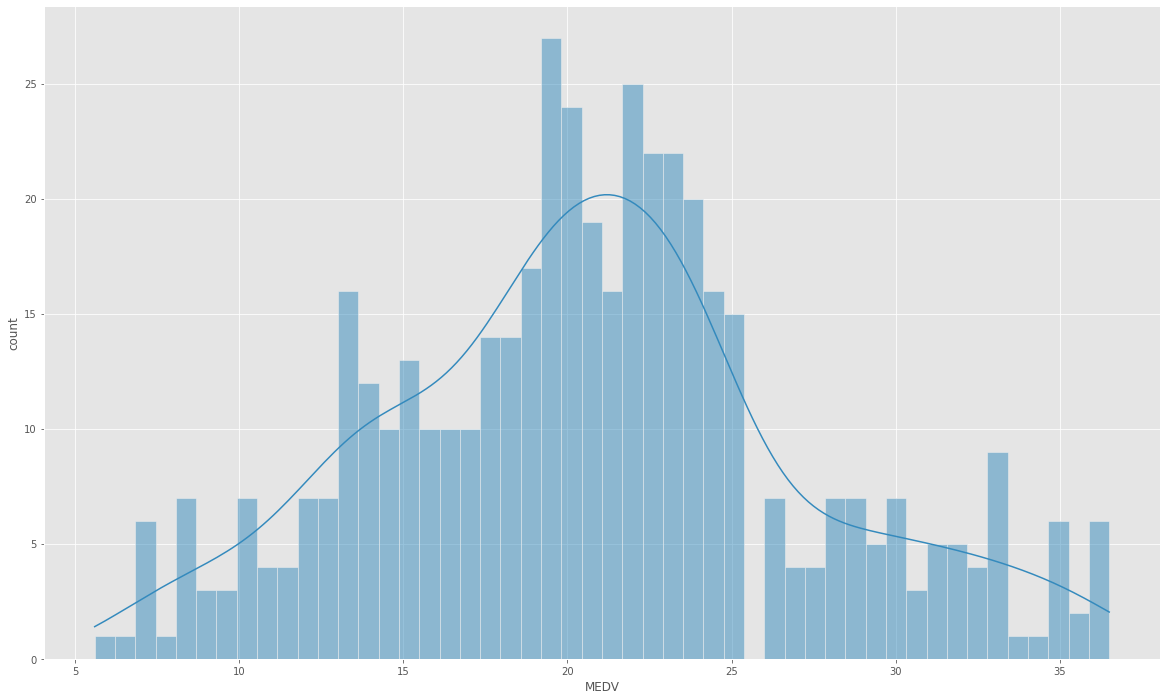

In [ ]:
plot_hist(df_bh.MEDV, _x_axis_label = "MEDV", _bins = 50, _width = 20, _height = 12, _outliers_removed = True)

## Создание выборок, масштабирование

In [ ]:
ml_features_columns = ['CRIM', 
                       'ZN', 
                       'INDUS', 
                       'CHAS', 
                       'NOX', 
                       'RM', 
                       'AGE', 
                       'DIS', 
                       'RAD', 
                       'TAX', 
                       'PTRATIO', 
                       'B', 
                       'LSTAT']

ml_target_column = ['MEDV'] 

In [ ]:
X_main = df_bh[ml_features_columns]
Y_main = df_bh[ml_target_column]

print(X_main.shape)
print(Y_main.shape)
print(df_bh[ml_features_columns].shape)
print(df_bh[ml_target_column].shape)

(506, 13)
(506, 1)
(506, 13)
(506, 1)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_main, 
                                                    Y_main, 
                                                    test_size=ML_TEST_SUBSET_SIZE_VALUE_CONST, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle = True)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

display(X_train.head())
display(X_test.head())
display(Y_train.head())
display(Y_test.head())

(404, 13)
(102, 13)
(404, 1)
(102, 1)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
477,15.02340,0.0,18.10,0,0.6140,5.304,97.3,2.1007,24,666.0,20.2,349.48,24.91
15,0.62739,0.0,8.14,0,0.5380,5.834,56.5,4.4986,4,307.0,21.0,395.62,8.47
332,0.03466,35.0,6.06,0,0.4379,6.031,23.3,6.6407,1,304.0,16.9,362.25,7.83
423,7.05042,0.0,18.10,0,0.6140,6.103,85.1,2.0218,24,666.0,20.2,2.52,23.29
19,0.72580,0.0,8.14,0,0.5380,5.727,69.5,3.7965,4,307.0,21.0,390.95,11.28


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09178,0.0,4.05,0,0.510,6.416,84.1,2.6463,5,296.0,16.6,395.50,9.04
274,0.05644,40.0,6.41,1,0.447,6.758,32.9,4.0776,4,254.0,17.6,396.90,3.53
491,0.10574,0.0,27.74,0,0.609,5.983,98.8,1.8681,4,711.0,20.1,390.11,18.07
72,0.09164,0.0,10.81,0,0.413,6.065,7.8,5.2873,4,305.0,19.2,390.91,5.52
452,5.09017,0.0,18.10,0,0.713,6.297,91.8,2.3682,24,666.0,20.2,385.09,17.27


,MEDV
477,12.0
15,19.9
332,19.4
423,13.4
19,18.2


,MEDV
173,23.6
274,32.4
491,13.6
72,22.8
452,16.1


In [ ]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)
display(X_train_std[:2])
display(X_test_std[:2])

array([[ 1.28770177, -0.50032012,  1.03323679, -0.27808871,  0.48925206,
        -1.42806858,  1.02801516, -0.80217296,  1.70689143,  1.57843444,
         0.84534281, -0.07433689,  1.75350503],
       [-0.33638447, -0.50032012, -0.41315956, -0.27808871, -0.15723342,
        -0.68008655, -0.43119908,  0.32434893, -0.62435988, -0.58464788,
         1.20474139,  0.4301838 , -0.5614742 ]])

array([[-0.39680933, -0.50032012, -1.00711147, -0.27808871, -0.39541229,
         0.14128239,  0.55591643, -0.54585271, -0.50779731, -0.65092617,
        -0.77195078,  0.42887165, -0.48121032],
       [-0.40079621,  1.2294987 , -0.66439105,  3.59597476, -0.93131473,
         0.62394249, -1.27525438,  0.12656515, -0.62435988, -0.90398873,
        -0.32270256,  0.44418004, -1.25709448]])

## Линейная регрессия с нуля

In [ ]:
features = torch.from_numpy(X_train_std).float()
true_w = torch.randn((features.shape[1]))
true_b = torch.zeros((1))
labels = torch.from_numpy(Y_train.values).float()

In [ ]:
def data_iter(BATCH_SIZE, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, BATCH_SIZE):
        j = indices[i: min(i + BATCH_SIZE, num_examples)]
        yield features[j, :], labels[j]

In [ ]:
for X, y in data_iter(BATCH_SIZE, features, labels):
    print(X, y)
    break

tensor([[-0.3870, -0.5003, -0.1881, -0.2781,  0.2426, -0.9115, -1.4219, -0.4743,
         -0.3912, -0.0785,  0.3961,  0.4047,  0.7242],
        [-0.4021,  0.5808, -0.8895, -0.2781, -1.1099,  0.4278,  0.0659,  0.7482,
         -0.6244, -0.7413,  0.3062,  0.4303, -0.7375],
        [-0.4052,  3.6080, -1.3818, -0.2781, -1.3056,  1.1560, -1.9548,  1.8065,
         -0.7409, -0.0122, -0.5923,  0.3064, -1.1275],
        [-0.3451,  0.3646, -1.0187, -0.2781,  0.7700,  1.2562,  0.8242, -0.8823,
         -0.5078, -0.8437, -2.3892,  0.3457, -0.6136],
        [-0.3956,  0.7970, -0.8793, -0.2781, -1.0929,  0.0594, -0.5600,  1.5162,
         -0.3912, -0.6268, -0.7720,  0.1801, -0.1742],
        [-0.2883, -0.5003, -0.4132, -0.2781, -0.1572, -0.5375, -1.4040,  0.3243,
         -0.6244, -0.5846,  1.2047,  0.3343, -0.8276],
        [-0.3974,  1.4457, -1.0957, -0.2781, -1.0164,  1.2167, -1.5113,  1.2551,
         -0.5078, -0.0363, -1.4009,  0.3741, -1.3500],
        [-0.3323,  0.3646, -1.0187, -0.2781,  0.

In [ ]:
w = torch.randn((NUM_INPUTS))
b = torch.zeros((1))

In [ ]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

In [ ]:
def lin_reg(X, w, b):
    return torch.mv(X,w)+b

In [ ]:
def sq_loss(y1, y):
    return ((y1 - y.reshape(y1.shape)) ** 2).mean()

In [ ]:
def sgd(params, LR):
    for param in params:
        param.data[:] = param - LR*param.grad

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    for X, y in data_iter(BATCH_SIZE, features, labels):   
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()
        l = sq_loss(lin_reg(X,w,b), y)
        l.backward()
        sgd([w,b], LR)

    train_l = sq_loss(lin_reg(features, w, b), labels)
    if epoch % 20 == 0:
        print('epoch %d, loss %f' % (epoch, train_l.mean().item()))

epoch 20, loss 21.680222
epoch 40, loss 22.507418
epoch 60, loss 21.763390
epoch 80, loss 21.943741
epoch 100, loss 22.039074


In [ ]:
print('Error in estimating w --- ', true_w - w.reshape(true_w.shape))
print('Error in estimating b --- ', true_b - b)
print('')
print('w --- ', w)
print('b --- ', b)

Error in estimating w ---  tensor([ 1.9362, -1.6688,  1.0148, -0.5632,  1.3374, -5.4742, -0.3827,  4.3074,
        -2.6027,  0.5673,  3.6043, -2.6091,  4.9303], grad_fn=<SubBackward0>)
Error in estimating b ---  tensor([-22.8209], grad_fn=<SubBackward0>)

w ---  tensor([-0.8657,  0.6727,  0.3537,  0.7726, -1.9695,  3.0807, -0.0634, -3.1854,
         2.3309, -1.6529, -2.0314,  1.1081, -3.5546], requires_grad=True)
b ---  tensor([22.8209], requires_grad=True)


## Линейная регрессия на torch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
features = torch.from_numpy(X_train_std).float()
true_w = torch.randn((features.shape[1]))
true_b = torch.zeros((1))
labels = torch.from_numpy(Y_train.values).float()

In [ ]:
dataset = TensorDataset(features, labels)

data_iter = DataLoader(dataset, BATCH_SIZE, shuffle=True)

for X, y in data_iter:
    print(X,'\n', y)
    break

tensor([[ 0.2325, -0.5003,  1.0332,  3.5960,  0.6339,  0.5181,  1.0101, -1.1517,
          1.7069,  1.5784,  0.8453,  0.2083, -1.2289],
        [-0.3979,  0.7970, -0.8793, -0.2781, -1.0929,  0.2330, -1.7903,  1.1189,
         -0.3912, -0.6268, -0.7720,  0.2529, -0.8586],
        [-0.3997, -0.5003, -1.0071, -0.2781, -0.3954,  0.7679,  0.2090, -0.4195,
         -0.5078, -0.6509, -0.7720,  0.3826, -0.7797],
        [-0.3850,  0.4511, -0.7443, -0.2781, -1.0674, -0.1269,  0.3807,  1.9954,
         -0.2747, -0.4461,  0.3512,  0.2172, -0.3249],
        [-0.3786, -0.5003, -0.1576, -0.2781, -0.1062, -0.8621,  0.3270,  0.0643,
         -0.6244, -0.6027,  0.0367,  0.4389, -0.1348],
        [-0.3994, -0.5003, -1.2380, -0.2781, -0.5826, -0.2426, -0.2273, -0.5686,
         -0.7409, -1.2715, -0.2329,  0.4442, -0.4235],
        [-0.4002,  1.2295, -1.4137, -0.2781, -1.0844,  0.2457, -0.8640,  2.3414,
         -0.9740, -0.4159,  0.6207,  0.4442, -0.9121],
        [-0.4027, -0.5003, -1.1001, -0.2781, -0.

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(NUM_INPUTS, 1)) #контейнер последовательных слоев
loss = torch.nn.MSELoss(reduction='mean')
trainer = torch.optim.SGD(model.parameters(), LR)

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    for X, y in data_iter:
        trainer.zero_grad()                          #сброс градиента
        l = loss(model(X).reshape(-1), y.reshape(-1)) 
        l.backward()                                 #считаем градиент
        trainer.step()                               #делаем шаг град.спуска
        
    l = loss(model(features).reshape(-1), labels.reshape(-1)) 
    if epoch % 20 == 0:
        print('\n epoch %d, loss: %f' % (epoch, l.item()), 
              '\n       w', model[0].weight.data,
              '\n       b', model[0].bias.data )


 epoch 20, loss: 21.985617 
       w tensor([[-0.9367,  0.6228, -0.0247,  0.7315, -1.9139,  3.2444, -0.2677, -2.8628,
          1.4669, -1.1451, -2.0719,  1.0833, -3.6498]]) 
       b tensor([22.7025])

 epoch 40, loss: 21.678911 
       w tensor([[-0.9833,  0.6167,  0.2273,  0.6844, -1.9907,  3.1459, -0.1518, -3.1010,
          2.0085, -1.5092, -2.0555,  1.1025, -3.5598]]) 
       b tensor([22.7498])

 epoch 60, loss: 21.736231 
       w tensor([[-1.0375,  0.6961,  0.2367,  0.7367, -2.0831,  3.3170, -0.1710, -3.1096,
          2.1465, -1.7002, -2.0385,  1.1064, -3.6911]]) 
       b tensor([22.7233])

 epoch 80, loss: 22.002583 
       w tensor([[-0.9840,  0.6239,  0.3472,  0.8294, -1.9234,  3.0960, -0.0826, -3.2072,
          2.3229, -1.6928, -2.0070,  1.0992, -3.5633]]) 
       b tensor([22.7769])

 epoch 100, loss: 21.886612 
       w tensor([[-1.0672,  0.7063,  0.2095,  0.8444, -2.0801,  3.1866, -0.2357, -3.0135,
          2.1839, -1.8285, -2.0390,  1.1675, -3.7204]]) 
       b te

In [ ]:
w = model[0].weight.data
print('Error in estimating w --- ', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b --- ', true_b - b)
print('')
print('w --- ', model[0].weight.data)
print('b --- ', model[0].bias.data)

Error in estimating w ---  tensor([[ 1.4597, -1.6054, -0.5449, -1.8420, -0.4427, -4.4070, -1.3702,  3.9263,
         -2.5801,  1.5227,  2.0426, -2.6191,  4.0259]])
Error in estimating b ---  tensor([-22.7891])

w ---  tensor([[-1.0672,  0.7063,  0.2095,  0.8444, -2.0801,  3.1866, -0.2357, -3.0135,
          2.1839, -1.8285, -2.0390,  1.1675, -3.7204]])
b ---  tensor([22.7891])
